# Lab07: Decision Trees
## Mehmet Gönen
### April 8, 2022

In [1]:
import numpy as np
import pandas as pd

def safelog2(x):
    if x == 0:
        return(0)
    else:
        return(np.log2(x))

## Importing Data

In [2]:
# read data into memory
data_set = np.genfromtxt("lab07_data_set.csv", delimiter = ",")

# get X and y values
X = data_set[:,[0, 1, 2, 3]]
y = data_set[:,4].astype(int)

# get number of classes, number of samples, and number of features
K = np.max(y)
N = X.shape[0]
D = X.shape[1]

# get train and test splits
train_indices = np.concatenate((np.arange(0, 25),
                                np.arange(50, 75),
                                np.arange(100, 125)))
test_indices = np.setdiff1d(range(N), train_indices)

X_train = X[train_indices,:]
y_train = y[train_indices]
X_test = X[test_indices,:]
y_test = y[test_indices]

# get numbers of train and test samples
N_train = len(y_train)
N_test = len(y_test)

## Initialization

In [3]:
# create necessary data structures
node_indices = {}
is_terminal = {}
need_split = {}

node_features = {}
node_splits = {}
node_frequencies = {}

# put all training instances into the root node
node_indices[1] = np.array(range(N_train))
is_terminal[1] = False
need_split[1] = True

## Tree Inference

In [4]:
# learning algorithm
while True:
    # find nodes that need splitting
    split_nodes = [key for key, value in need_split.items()
                   if value == True]
    # check whether we reach all terminal nodes
    if len(split_nodes) == 0:
        break
    # find best split positions for all nodes
    for split_node in split_nodes:
        data_indices = node_indices[split_node]
        need_split[split_node] = False
        node_frequencies[split_node] = [np.sum(y_train[data_indices] == c + 1)
                                        for c in range(K)]
        if len(np.unique(y_train[data_indices])) == 1:
            is_terminal[split_node] = True
        else:
            is_terminal[split_node] = False

            best_scores = np.repeat(0.0, D)
            best_splits = np.repeat(0.0, D)
            for d in range(D):
                unique_values = np.sort(np.unique(X_train[data_indices, d]))
                split_positions = (unique_values[1:len(unique_values)] + \
                                   unique_values[0:(len(unique_values) - 1)]) / 2
                split_scores = np.repeat(0.0, len(split_positions))
                for s in range(len(split_positions)):
                    left_indices = data_indices[X_train[data_indices, d] > \
                                   split_positions[s]]
                    right_indices = data_indices[X_train[data_indices, d] <= \
                                    split_positions[s]]
                    split_scores[s] = -(len(left_indices) / len(data_indices) * \
                                        np.sum([np.mean(y_train[left_indices] == c + 1) * \
                                                safelog2(np.mean(y_train[left_indices] == c + 1))
                                                for c in range(K)]) + \
                                        len(right_indices) / len(data_indices) * \
                                        np.sum([np.mean(y_train[right_indices] == c + 1) * \
                                                safelog2(np.mean(y_train[right_indices] == c + 1))
                                                for c in range(K)]))
                best_scores[d] = np.min(split_scores)
                best_splits[d] = split_positions[np.argmin(split_scores)]
            # decide where to split on which feature
            split_d = np.argmin(best_scores)

            node_features[split_node] = split_d
            node_splits[split_node] = best_splits[split_d]
            
            # create left node using the selected split
            left_indices = data_indices[X_train[data_indices, split_d] > \
                           best_splits[split_d]]
            node_indices[2 * split_node] = left_indices
            is_terminal[2 * split_node] = False
            need_split[2 * split_node] = True
      
            # create right node using the selected split
            right_indices = data_indices[X_train[data_indices, split_d] <= \
                            best_splits[split_d]]
            node_indices[2 * split_node + 1] = right_indices
            is_terminal[2 * split_node + 1] = False
            need_split[2 * split_node + 1] = True

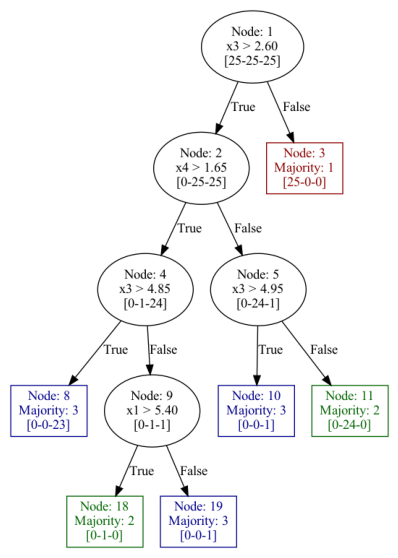

In [5]:
def draw_tree():
    import pygraphviz as pgv

    class_colors = ["darkred", "darkgreen", "darkblue"]

    T = pgv.AGraph(directed = True, strict = True, rankdir = "UB")

    for key, value in is_terminal.items():
        if is_terminal[key] == False:
            T.add_node(key, shape = "ellipse", color = "black", 
                       label = "Node: {:d}\nx{:d} > {:.2f}\n[{:d}-{:d}-{:d}]".format(key,
                                                                                     node_features[key] + 1,
                                                                                     node_splits[key],
                                                                                     node_frequencies[key][0],
                                                                                     node_frequencies[key][1],
                                                                                     node_frequencies[key][2]))
        else:
            T.add_node(key, shape = "rectangle", 
                       color = class_colors[np.argmax(node_frequencies[key])],
                       fontcolor = class_colors[np.argmax(node_frequencies[key])],
                       label = "Node: {:d}\nMajority: {:d}\n[{:d}-{:d}-{:d}]".format(key,
                                                                                     np.argmax(node_frequencies[key]) + 1,
                                                                                     node_frequencies[key][0],
                                                                                     node_frequencies[key][1],
                                                                                     node_frequencies[key][2]))

    for key, value in is_terminal.items():
        if key > 1:
            if key % 2 == 0:
                T.add_edge(key // 2, key, label = "True", color = "black")
            else:
                T.add_edge(key // 2, key, label = "False", color = "black")

    T.layout("dot")
    T.draw("decision_tree.png")

draw_tree()
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 10))
plt.axis("off")
plt.imshow(plt.imread("decision_tree.png"))
plt.show()

## Rule Extraction

In [6]:
# extract rules
terminal_nodes = [key for key, value in is_terminal.items()
                  if value == True]
for terminal_node in terminal_nodes:
    index = terminal_node
    rules = np.array([])
    while index > 1:
        parent = np.floor(index / 2)
        if index % 2 == 0:
            # if node is left child of its parent
            rules = np.append(rules, 
                              "x{:d} > {:.2f}".format(node_features[parent] + 1,
                                                      node_splits[parent]))
        else:
            # if node is right child of its parent
            rules = np.append(rules,
                              "x{:d} <= {:.2f}".format(node_features[parent] + 1,
                                                       node_splits[parent]))
        index = parent
    rules = np.flip(rules)
    print("{} => {}".format(rules, node_frequencies[terminal_node]))

['x3 <= 2.60'] => [25, 0, 0]
['x3 > 2.60' 'x4 > 1.65' 'x3 > 4.85'] => [0, 0, 23]
['x3 > 2.60' 'x4 <= 1.65' 'x3 > 4.95'] => [0, 0, 1]
['x3 > 2.60' 'x4 <= 1.65' 'x3 <= 4.95'] => [0, 24, 0]
['x3 > 2.60' 'x4 > 1.65' 'x3 <= 4.85' 'x1 > 5.40'] => [0, 1, 0]
['x3 > 2.60' 'x4 > 1.65' 'x3 <= 4.85' 'x1 <= 5.40'] => [0, 0, 1]


## Training Performance

In [7]:
# traverse tree for training data points
y_predicted = np.repeat(0, N_train)
for i in range(N_train):
    index = 1
    while True:
        if is_terminal[index] == True:
            y_predicted[i] = np.argmax(node_frequencies[index]) + 1
            break
        else:
            if X_train[i, node_features[index]] > node_splits[index]:
                index = index * 2
            else:
                index = index * 2 + 1
confusion_matrix = pd.crosstab(y_predicted, y_train,
                               rownames = ["y_predicted"],
                               colnames = ["y_train"])
print(confusion_matrix)

y_train       1   2   3
y_predicted            
1            25   0   0
2             0  25   0
3             0   0  25


## Test Performance

In [8]:
# traverse tree for test data points
y_predicted = np.repeat(0, N_test)
for i in range(N_test):
    index = 1
    while True:
        if is_terminal[index] == True:
            y_predicted[i] = np.argmax(node_frequencies[index]) + 1
            break
        else:
            if X_test[i, node_features[index]] > node_splits[index]:
                index = index * 2
            else:
                index = index * 2 + 1
confusion_matrix = pd.crosstab(y_predicted, y_test,
                               rownames = ["y_predicted"],
                               colnames = ["y_test"])
print(confusion_matrix)

y_test        1   2   3
y_predicted            
1            25   0   0
2             0  23   2
3             0   2  23
